In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from flask import Flask, request, render_template
import re
import matplotlib.pyplot as plt
import json
import numpy as np
import nltk
import seaborn as sns

In [4]:
credit = pd.read_csv(r'/Users/iqrabismi/Desktop/projects/MoviestRecommendationSystem/MoviesRecommendationSystem/tmdb_5000_credits.csv')

In [5]:
credit.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## 2. Collaborative Filtering 

In [12]:
movies= pd.read_csv(r'/Users/iqrabismi/Desktop/ml-latest/movies.csv')

In [14]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [17]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [15]:
rating= pd.read_csv(r'/Users/iqrabismi/Desktop/projects/MoviestRecommendationSystem/MoviesRecommendationSystem/ratings_small.csv')

In [16]:
rating.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [18]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## EDA

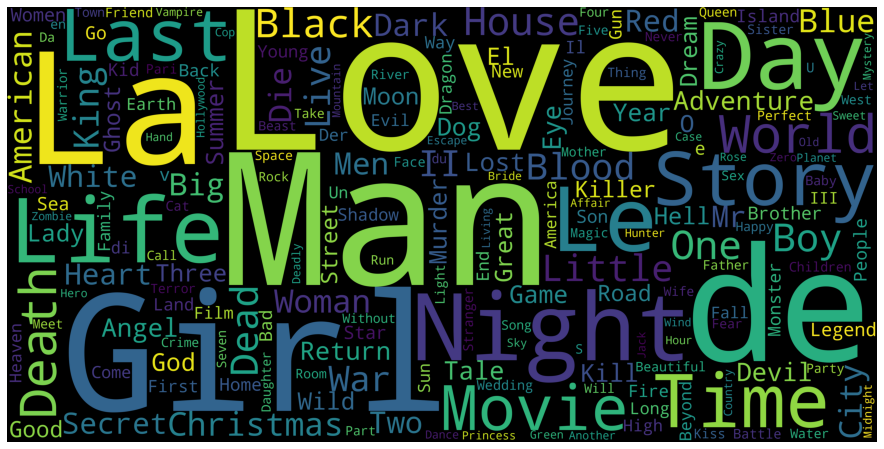

In [19]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [21]:
# Get summary statistics of rating
rating['rating'].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

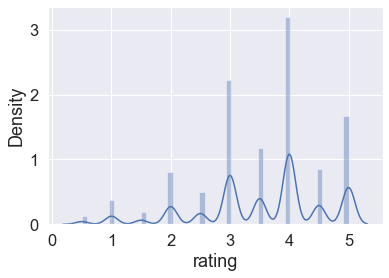

In [23]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(rating['rating'].fillna(rating['rating'].median()))

It seems that the ratings provided by users are generally high, with a mean rating of 3.58 out of 5. A large portion of the movies have received ratings of 4 and 5. This could indicate that the 5-level rating system may not have been the best choice, as users may have different rating styles, and some may be more generous with their ratings than others. Additionally, since each user has rated at least 20 movies, it is unlikely that this distribution is simply a result of chance variation in the quality of the movies. To further investigate, let's take a closer look at a subset of 20 movies with the highest ratings.

In [24]:
# Join all 3 files into one dataframe
df = movies.merge(rating, on= 'movieId')
# Display 20 movies with highest ratings
df[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
99957,The Beatles: Eight Days a Week - The Touring Y...,Documentary,5.0
49811,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
49817,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
19597,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,5.0
49819,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
19594,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,5.0
49822,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
49823,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
19589,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,5.0
49830,Miracle on 34th Street (1947),Comedy|Drama,5.0


##### Taking the count for Genre

In [25]:
df.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179


In [27]:
def f(x):
    return x.split('|')

In [29]:
df['genres'] = df['genres'].apply(f)

In [40]:
df.genres.values[0]
    

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', []]

In [41]:
genre=[]

for i in df.genres.values:
    for j in i:
        if type(j) != list:
            genre.append(j)

In [49]:
from collections import Counter
C= Counter(genre)

print(C.most_common(5)) #Top five most watched genre

[('Drama', 44725), ('Comedy', 38022), ('Action', 27029), ('Thriller', 25240), ('Adventure', 22014)]


There are two types of Collaborative filtering

1. User-User Collaborative Filtering: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.
2. Item-Item Collaborative Filtering: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

 

In collaborative filtering, we construct a similarity matrix to measure the similarity between different users or items. For user-user collaborative filtering, we use a user-similarity matrix that measures the similarity between any two pairs of users using a distance metric. Similarly, for item-item collaborative filtering, we use an item-similarity matrix that measures the similarity between any two pairs of items.

Three commonly used distance similarity metrics in collaborative filtering are Jaccard Similarity, Cosine Similarity, and Pearson Similarity. Jaccard Similarity measures similarity based on the number of users who have rated both items A and B, divided by the number of users who have rated either A or B. It is typically used when we only have a boolean value (e.g. a product being bought or an add being clicked) instead of a numeric rating. Cosine Similarity measures similarity(mostly used in content-based filtering) as the cosine of the angle between the two vectors of the item vectors of A and B. Pearson Similarity measures similarity as the Pearson coefficient between the two vectors. In this implementation, I will use Pearson Similarity for the purpose of diversity.

In [52]:
# Fill NaN values in user_id and movie_id column with 0
rating['user_id'] = rating['userId'].fillna(0)
rating['movie_id'] = rating['movieId'].fillna(0)

# Replace NaN values in rating column with average of all values
rating['rating'] = rating['rating'].fillna(rating['rating'].mean())

In [55]:
rating.head(2)

,userId,movieId,rating,timestamp,user_id,movie_id
0,1,31,2.5,1260759144,1,31
1,1,1029,3.0,1260759179,1,1029


In [106]:
## taking the subset of data 
small_rating = rating.sample(frac=0.2)

In [107]:
small_rating= small_rating[['userId', 'movieId', 'rating']]

In [108]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(small_rating, test_size=0.2)

Creating a user-item matrix is a common step in the process of building a recommendation system. The matrix is typically used to represent the interactions between users and items, such as ratings or purchase history.

To create a user-item matrix, I used the training data that contains 80% of the ratings.Each cell in the matrix represents the rating given by the user to the item. 

In [109]:
train_data_matrix = train_data.values
test_data_matrix = test_data.values

In [110]:
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16000, 3)
(4001, 3)


The Pearson Correlation Coefficient is a measure of the linear correlation between two variables. To calculate it, I use the pairwise_distances function from the sklearn library. This function allows to take a distance matrix as input and calculates the pairwise distances between rows or columns of the input matrix.

In [111]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[ 1.          0.89402958  0.10704678 -0.03159918]
 [ 0.89402958  1.         -0.34973068 -0.4760348 ]
 [ 0.10704678 -0.34973068  1.          0.99037489]
 [-0.03159918 -0.4760348   0.99037489  1.        ]]


In [112]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.          0.01135671 -0.00261971]
 [ 0.01135671  1.         -0.02852268]
 [-0.00261971 -0.02852268  1.        ]]


With the similarity matrix, I can now predict the missing ratings in the data. These predictions can then be compared with the test data to evaluate the quality of the recommender model.

For user-user collaborative filtering, I will use the similarity between two users (A and B, for example) as weights that are multiplied by the ratings of a similar user B, which are then corrected for the average rating of that user. I will also normalize the ratings to ensure they stay between 1 and 5. Finally, I will sum the average ratings for the user I am trying to predict. The idea behind this is that some users may have a tendency to give high or low ratings to all movies, so the relative difference in the ratings that these users give is more important than the absolute values.

In [127]:
# Function to predict ratings
def predict(rating, similarity, type='user'):
    if type == 'user':
        mean_user_rating = rating.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (rating - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = rating.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        
    return pred

Evaluation
To evaluate the accuracy of predicted ratings in a recommendation system, one popular metric that is often used is the Root Mean Squared Error (RMSE). To calculate this metric, I will use the mean_squared_error function from the sklearn library, which calculates the mean squared error between the predicted ratings and the actual ratings. The RMSE is then calculated as the square root of the mean squared error.

I will use the mean_squared_error function as my validation metric to compare the results of user-based collaborative filtering and item-based collaborative filtering. After comparing the two methods, it seems that the user-based collaborative filtering approach gives a better result

In [128]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.

    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [129]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 17516.28898915243
Item-based CF RMSE: 20809.378741377524


In [130]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 12123.303864550586
Item-based CF RMSE: 808.845160082511


The Root Mean Square Error (RMSE) of the training model is a metric that measures how well the model explains the signal and noise in the data. I noticed that my RMSE is quite large, which could indicate that I have overfitted the training data.

Overall, Memory-based Collaborative Filtering is a straightforward approach that produces reasonable prediction quality. However, it has some limitations:

It does not address the cold-start problem, which occurs when new users or items enter the system and have no previous ratings.
It struggles with sparse data, making it difficult to find users who have rated the same items.
It performs poorly when new users or items without any ratings enter the system.
It tends to recommend popular items, rather than personalized recommendations.
It's worth noting that, in practice, it's common to use a combination of different approaches to tackle the limitations of each individual method.

### Alternative Approach

1. Matrix Factorization (MF) is a technique that assumes that the preferences or attitudes of a user can be represented by a small number of hidden latent factors, also known as embeddings, which represent different characteristics for users and items. This can be done using various methods including Support Vector Decomposition (SVD), Probabilistic Matrix Factorization (PMF), and Non-Negative Matrix Factorization (NMF).

2. Another approach is to use Clustering-based algorithm such as KNN. This method is similar to memory-based recommendation systems as it uses similarities between users and/or items as weights to predict a rating for a user and an item. However, in this approach, similarities are calculated using an unsupervised learning model rather than Pearson correlation or cosine similarity.

3. Lastly, Neural Nets and Deep Learning techniques can also be used for recommendation systems. Similar to Model-based Matrix Factorization, this method decomposes the original sparse matrix into a product of two low-rank matrices. However, for neural net implementation, the matrices do not have to be orthogonal and the model learns the values of the embedding matrix itself. The user latent features and item latent features are looked up from the embedding matrices for a specific user-item combination, which are then passed through linear and non-linear layers to learn the corresponding weights using optimization algorithms such as Adam or SGD.